In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [4]:
# Adaptar a las rutas de los archivos
eventos = pd.read_json("../../simulation.jsonlines", lines=True)
planes = pd.read_json("../../plans.jsonlines", lines=True)

In [5]:
eventos.eventType.unique()

array(['Truck departed', 'Truck initialized', 'Truck received packets',
       'Truck arrived', 'Truck started delivering',
       'Truck ended delivering', 'Truck departed to depot',
       'Truck ended route'], dtype=object)

In [6]:
eventos.columns

Index(['eventDescription', 'eventTime', 'eventType', 'simulationId',
       'truckId'],
      dtype='object')

## Tiempo de viaje de Camiones 

In [7]:
camiones = []
for simId in planes.simulationId.unique():
    for truck in planes[planes.simulationId == simId].trucks.values[0]:
        camiones.append(pd.DataFrame(truck["route"]).assign(simulationId=simId, truckId=truck["truck_id"]))
camiones = pd.concat(camiones)

In [8]:
tiempos_plan = camiones.sort_values(["simulationId","truckId"]).assign(duration=lambda x: x["duration"]*1000).groupby(["simulationId","truckId"]).duration.agg(list).reset_index()
tiempos_plan.rename(columns={"duration":"tiempo_plan"}, inplace=True)
tiempos_plan

,simulationId,truckId,tiempo_plan
0,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3321FBL,"[614000, 397000, 259000, 349000, 384000, 26800..."
1,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3953RLD,"[4164000, 4064000]"
2,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5030LXK,"[189000, 1522000, 1655000, 1125000, 2093000, 6..."
3,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5534TPH,"[630000, 496000, 725000, 680000, 491000, 53400..."
4,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,6270NFM,"[621000, 130000, 294000, 74000, 403000]"
...,...,...,...
635,fea13535-ade6-4215-96ca-dab5b4ef309b,0013DYS,"[3714000, 3663000]"
636,fea13535-ade6-4215-96ca-dab5b4ef309b,3953RLD,"[208000, 670000, 260000, 492000, 178000, 79900..."
637,fea13535-ade6-4215-96ca-dab5b4ef309b,5534TPH,"[589000, 909000, 725000, 455000, 297000, 82900..."
638,fea13535-ade6-4215-96ca-dab5b4ef309b,6270NFM,"[445000, 223000, 219000, 408000, 1538000, 1591..."


En la tabla anterior podemos ver un dataset con el id de cada uno de los camiones , el tiempo estimado de viaje, y el tiempo real 

In [9]:
eventos = eventos.sort_values(["simulationId", "truckId", "eventTime"])
eventos["prev_event"] = eventos.groupby(["truckId", "simulationId"])["eventType"].shift(1)
eventos["prev_time"] = eventos.groupby(["truckId", "simulationId"])["eventTime"].shift(1)
eventos["delta"] = eventos.eventTime - eventos.prev_time
tiempos_sim = eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].sort_values(["simulationId","truckId", "eventTime"]).groupby(["simulationId","truckId"]).delta.agg(list).reset_index()
tiempos_sim.rename(columns={"delta":"tiempo_sim"}, inplace=True)
tiempos_sim

,simulationId,truckId,tiempo_sim
0,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3321FBL,"[0.0, 482520.0, 311850.0, 418680.0, 458820.0, ..."
1,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3953RLD,"[0.0, 4524090.0]"
2,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5030LXK,"[231120.0, 1811130.0, 1950900.0, 0.0, 2418600...."
3,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5534TPH,"[791640.0, 618480.0, 894330.0, 827790.0, 59145..."
4,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,6270NFM,"[776190.0, 161310.0, 357180.0, 88740.0, 474390.0]"
...,...,...,...
635,fea13535-ade6-4215-96ca-dab5b4ef309b,0013DYS,"[3901230.0, 3846930.0]"
636,fea13535-ade6-4215-96ca-dab5b4ef309b,3953RLD,"[252840.0, 801060.0, 310980.0, 0.0, 210720.0, ..."
637,fea13535-ade6-4215-96ca-dab5b4ef309b,5534TPH,"[723990.0, 1106700.0, 871290.0, 545490.0, 3529..."
638,fea13535-ade6-4215-96ca-dab5b4ef309b,6270NFM,"[576960.0, 287250.0, 278220.0, 516150.0, 19308..."


In [10]:
retrasos = tiempos_sim.merge(tiempos_plan, on=["simulationId","truckId"]).dropna().reset_index(drop=True)
retrasos

,simulationId,truckId,tiempo_sim,tiempo_plan
0,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3321FBL,"[0.0, 482520.0, 311850.0, 418680.0, 458820.0, ...","[614000, 397000, 259000, 349000, 384000, 26800..."
1,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3953RLD,"[0.0, 4524090.0]","[4164000, 4064000]"
2,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5030LXK,"[231120.0, 1811130.0, 1950900.0, 0.0, 2418600....","[189000, 1522000, 1655000, 1125000, 2093000, 6..."
3,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5534TPH,"[791640.0, 618480.0, 894330.0, 827790.0, 59145...","[630000, 496000, 725000, 680000, 491000, 53400..."
4,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,6270NFM,"[776190.0, 161310.0, 357180.0, 88740.0, 474390.0]","[621000, 130000, 294000, 74000, 403000]"
...,...,...,...,...
635,fea13535-ade6-4215-96ca-dab5b4ef309b,0013DYS,"[3901230.0, 3846930.0]","[3714000, 3663000]"
636,fea13535-ade6-4215-96ca-dab5b4ef309b,3953RLD,"[252840.0, 801060.0, 310980.0, 0.0, 210720.0, ...","[208000, 670000, 260000, 492000, 178000, 79900..."
637,fea13535-ade6-4215-96ca-dab5b4ef309b,5534TPH,"[723990.0, 1106700.0, 871290.0, 545490.0, 3529...","[589000, 909000, 725000, 455000, 297000, 82900..."
638,fea13535-ade6-4215-96ca-dab5b4ef309b,6270NFM,"[576960.0, 287250.0, 278220.0, 516150.0, 19308...","[445000, 223000, 219000, 408000, 1538000, 1591..."


In [11]:
arr = np.array(retrasos.apply(lambda x: list(zip(x.tiempo_plan, x.tiempo_sim)), axis=1).explode())
arr = np.array(arr.tolist())
x = arr[:,0].reshape(-1,1) / 1000 #estimated time
y = arr[:,1].reshape(-1,1) / 1000 # real time 


## Tiempos de entrega de los paquetes

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

travelmodel = RandomForestRegressor(n_estimators=100)

# Split data 
x_train, x_test, y_train, y_test = train_test_split(x, y.ravel(), test_size=0.3, random_state=42)

travelmodel.fit(x_train, y_train)

#Make predictions
pred_real_time = travelmodel.predict(x_test)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate  métrics
mae = mean_absolute_error(y_test, pred_real_time)
mse = mean_squared_error(y_test, pred_real_time)
rmse = np.sqrt(mse)  # o directamente: mean_squared_error(y_test, pred_real_time, squared=False)
r2 = r2_score(y_test, pred_real_time)

# Show results
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Mean Absolute Error: 218.33829905466237
Mean Squared Error: 263334.13972826046
Root Mean Squared Error: 513.1609296587771
R² Score: 0.7438958108442314


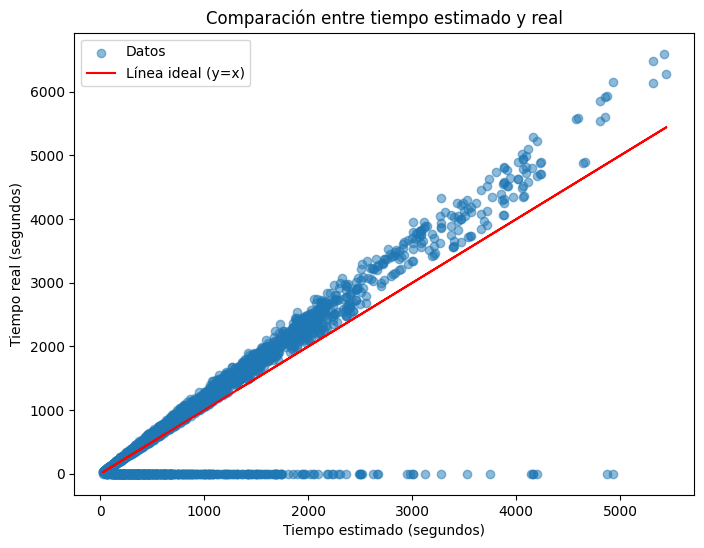

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.5, label='Datos')
plt.plot(x, x, color='red', label='Línea ideal (y=x)')
plt.xlabel('Tiempo estimado (segundos)')
plt.ylabel('Tiempo real (segundos)')
plt.title('Comparación entre tiempo estimado y real')
plt.legend()
plt.show()

In [12]:
# Entrenar modelo
travelModel = LinearRegression()
travelModel.fit(x, y)

# Guardar modelo
with open('travelModel.pkl', 'wb') as f:
    pickle.dump(travelModel, f)


In [13]:
tiemposEntrega = eventos[eventos.eventType=="Truck ended delivering"][["truckId", "delta"]]

# Label encoding
le = LabelEncoder()
tiemposEntrega["truckId"] = le.fit_transform(tiemposEntrega["truckId"])

# Entrenar modelo
deliveryModel = LinearRegression()
deliveryModel.fit(tiemposEntrega["truckId"].values.reshape(-1,1), tiemposEntrega["delta"].values.reshape(-1,1))

# Guardar modelo y label encoder
with open('deliveryModel.pkl', 'wb') as f:
    pickle.dump(deliveryModel, f)
    
with open('le.pkl', 'wb') as f:
    pickle.dump(le, f)


## Listamos variables

In [ ]:
entregas 